### Create a Graph Neural Network Model based on the _C. elegans_ connectome.
---
Last Modified: 15 November, 2023

In [2]:
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from utils import ROOT_DIR, RAW_FILES
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
from preprocess._utils import preprocess_connectome
from torch_geometric.utils import to_dense_adj, dense_to_sparse

CUDA device found.


num_nodes, num_node_features, num_features, num_edge_features, num_edge_types: (302, 512, 512, 2, 1)

edge attributes: electrical weights in 1st column, chemical weights in 2nd column.


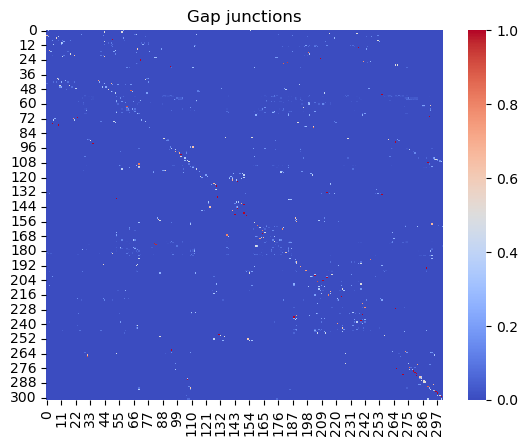

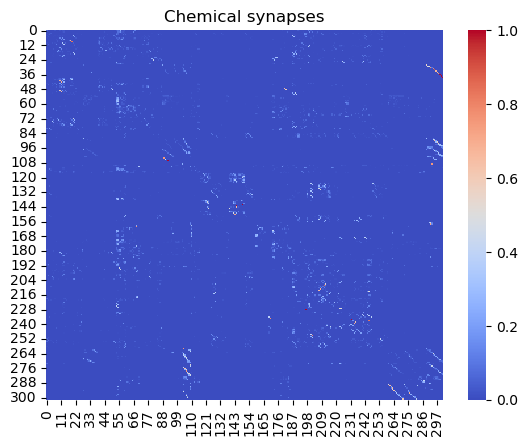

In [3]:
# @title Testing saving and loading C. elegans connectome data

raw_dir = os.path.join(ROOT_DIR, "data/raw")
preprocess_connectome(raw_dir=raw_dir, raw_files=RAW_FILES)

input_size = 302
graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)
connectome = Data(**graph_tensors)
assert connectome.num_nodes == input_size, "Input size must match number of nodes in connectome."
print(
    f"num_nodes, num_node_features, num_features, num_edge_features, num_edge_types: {connectome.num_nodes, connectome.num_node_features, connectome.num_features, connectome.num_edge_features, connectome.num_edge_types}\n"
)

# edge_index = torch.tensor([[0, 0, 1, 2, 3],
#                            [0, 1, 0, 3, 0]])
# edge_attr = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
# to_dense_adj(edge_index=edge_index, edge_attr=edge_attr)

print("edge attributes: electrical weights in 1st column, chemical weights in 2nd column.")
elec_weights = to_dense_adj(
    edge_index=connectome.edge_index, edge_attr=connectome.edge_attr[:, 0]
).squeeze(0)
chem_weights = to_dense_adj(
    edge_index=connectome.edge_index, edge_attr=connectome.edge_attr[:, 1]
).squeeze(0)

# print(connectome.edge_index.shape, connectome.edge_attr.shape)
# print(elec_weights.shape, chem_weights.shape)

sns.heatmap(elec_weights, cmap="coolwarm")
plt.title("Gap junctions")
plt.show()
sns.heatmap(chem_weights, cmap="coolwarm")
plt.title("Chemical synapses")
plt.show()

In [ ]:
# @title Graph Convolutional Network (GCN): Core / Inner Model for NetworkGCN (work-in-progress)
# TODO: Work on this model more.
class GCNModel(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) model for _C. elegans_ connectome graph.
    THIS IS A WORK-IN-PROGRESS ...
    """

    def __init__(
        self,
        input_size,
        hidden_size,
    ):
        super().__init__()
        # Load the connectome graph
        graph_tensors = torch.load(
            os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
        )
        graph = Data(**graph_tensors)
        assert graph.num_nodes == input_size, "Input size must match number of nodes in connectome."

        # Set attributes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.edge_index = graph.edge_index
        self.edge_attr = graph.edge_attr

        # Define the GCN layers
        self.elec_conv = GCNConv(
            in_channels=-1,
            out_channels=self.hidden_size,
            improved=True,
        )  # electrical synapse convolutions,
        self.chem_conv = GCNConv(
            in_channels=-1,
            out_channels=self.hidden_size,
            improved=True,
        )  # chemical synapse convolutions
        self.hid_proj = torch.nn.Linear(
            in_features=2 * self.hidden_size, out_features=self.hidden_size
        )  # projection to latent space (i.e hidden state)

        # Check if first forward call
        self.first_forward = True
        self.device = torch.device("cpu")
        self.random_projection = None

    def forward(self, x):
        """
        GCNConv layers:
            - input: node features (|V|, F_in), edge indices (2,|E|), edge weights (|E|) (optional)
            - output: node features (|V|, F_out)

        x: input tensor w/ shape (batch_size, seq_len, input_size)

        input_size = 302, which is the number of nodes |V| in the connectome graph of _C. elegans_.
        """
        # Check that the input shape is as expected
        batch_size, seq_len, input_size = x.shape
        assert input_size == self.input_size, "Incorrectly shaped input tensor."

        # Move GCNConv layers to same device as data
        if self.first_forward:
            self.device = x.device
            self.elec_conv = self.elec_conv.to(self.device)
            self.chem_conv = self.chem_conv.to(self.device)
            self.random_projection = torch.randn(
                self.input_size,
                seq_len,
                requires_grad=False,
                dtype=torch.float,
                device=self.device,
            )  # (hidden_size, seq_len)
            self.first_forward = False

        # Reshape the input (batch_size, |V| = input_size = 302, seq_len)
        x = torch.transpose(x, 1, 2)

        # Create a list of Data objects.
        data_list = [
            Data(
                x=x[i].to(self.device),
                edge_index=self.edge_index.to(self.device),
                edge_attr=self.edge_attr.to(self.device),
            )
            for i in range(x.size(0))
        ]

        # Convert this list into a Batch object.
        batch = Batch.from_data_list(data_list)

        # Chemical synapses convolution
        elec_weight = batch.edge_attr[:, 0]
        elec_hidden = self.elec_conv(
            x=batch.x,
            edge_index=batch.edge_index,
            edge_weight=elec_weight,
        )

        # Gap junctions convolution
        chem_weight = batch.edge_attr[:, 1]
        chem_hidden = self.chem_conv(
            x=batch.x,
            edge_index=batch.edge_index,
            edge_weight=chem_weight,
        )

        # Concatenate into a single latent
        hidden = torch.cat([elec_hidden, chem_hidden], dim=-1)

        # Transform back to the input space
        x = self.hid_proj(hidden).T  # (batch_size, input_size, hidden_size)
        x = x.reshape(self.hidden_size, batch_size, self.input_size)
        x = x @ self.random_projection  # (hidden_size, batch_size, seq_len)
        x = x.reshape(batch_size, seq_len, self.hidden_size)

        return x  # (batch_size, seq_len, hidden_size)